# 医療保険の費用帯予測
～「医療データを使って保険の費用帯を予測しよう！」

In [54]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sample = pd.read_csv("./sample_submit.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (1200, 8) Test: (800, 7) Sample: (800, 2)


### データセットの調査

In [55]:
print(train.isnull().sum())
print()
print(test.isnull().sum())

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64


In [56]:
train.head()

,id,age,sex,bmi,children,smoker,region,charges
0,1,45,male,46.561704,5,no,southeast,0
1,2,18,female,23.572081,3,no,southwest,0
2,4,28,female,38.670352,0,no,southeast,0
3,5,46,female,45.614196,0,no,southwest,0
4,10,27,male,38.769610,0,no,northeast,0


### 相関関係のなさそうな項目を削除

In [57]:
train = train.drop(columns=["id","sex","region"])
test = test.drop(columns=["id","sex","region"])
print(train.head())
print(test.head())

   age        bmi  children smoker  charges
0   45  46.561704         5     no        0
1   18  23.572081         3     no        0
2   28  38.670352         0     no        0
3   46  45.614196         0     no        0
4   27  38.769610         0     no        0
   age        bmi  children smoker
0   28  32.694647         3     no
1   22  29.606817         0     no
2   38  33.567011         2    yes
3   22  29.216607         0     no
4   47  32.982643         3    yes


### カテゴリ変数をダミー変数に変換

In [58]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
train.head()

,age,bmi,children,charges,smoker_no,smoker_yes
0,45,46.561704,5,0,1,0
1,18,23.572081,3,0,1,0
2,28,38.670352,0,0,1,0
3,46,45.614196,0,0,1,0
4,27,38.769610,0,0,1,0


In [59]:
test.head()

,age,bmi,children,smoker_no,smoker_yes
0,28,32.694647,3,1,0
1,22,29.606817,0,1,0
2,38,33.567011,2,0,1
3,22,29.216607,0,1,0
4,47,32.982643,3,0,1


### 目的変数の抽出

In [60]:
y = train["charges"].values
print(y)
print()
#ONE-HOTに変換
y = keras.utils.to_categorical(y)
print(y)

[0 0 0 ... 0 0 0]

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


### 不要カラムの削除

In [61]:
train = train.drop(columns=["charges"])
train.head()

,age,bmi,children,smoker_no,smoker_yes
0,45,46.561704,5,1,0
1,18,23.572081,3,1,0
2,28,38.670352,0,1,0
3,46,45.614196,0,1,0
4,27,38.769610,0,1,0


In [62]:
train_data = train.values
train_labels = y
test_data = test.values


### 正規化

In [63]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std


### モデルの構築

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(train_data.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

#model.compile(optimizer='adam', 
#              loss='mse', 
#              metrics=['mae'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### 学習

In [65]:
from tensorflow import keras

# 完了したエポックごとに1つのドットを印刷して、トレーニングの進捗状況を表示する
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# 学習データ(train_data)のうち、20％が検証データ（validation）として使用される    
history = model.fit(train_data, 
                    train_labels,
                    batch_size=64,
                    epochs=200,
                    validation_split=0.2,
                    callbacks=[early_stop,PrintDot()]) 

Train on 960 samples, validate on 240 samples
Epoch 1/200
960/960 [==============================] - 0s 174us/step - loss: 0.4562 - accuracy: 0.9073 - val_loss: 0.3447 - val_accuracy: 0.9042

.Epoch 2/200
960/960 [==============================] - 0s 102us/step - loss: 0.2739 - accuracy: 0.9344 - val_loss: 0.3014 - val_accuracy: 0.9042
.Epoch 3/200
960/960 [==============================] - 0s 99us/step - loss: 0.2508 - accuracy: 0.9271 - val_loss: 0.3144 - val_accuracy: 0.9042
.Epoch 4/200
960/960 [==============================] - 0s 45us/step - loss: 0.2382 - accuracy: 0.9260 - val_loss: 0.3227 - val_accuracy: 0.9000
.Epoch 5/200
960/960 [==============================] - 0s 28us/step - loss: 0.2339 - accuracy: 0.9323 - val_loss: 0.3209 - val_accuracy: 0.9083
.Epoch 6/200
960/960 [==============================] - 0s 29us/step - loss: 0.2254 - accuracy: 0.9333 - val_loss: 0.3249 - val_accuracy: 0.9042
.Epoch 7/200
960/960 [==============================] - 0s 29us/step - loss: 0.227

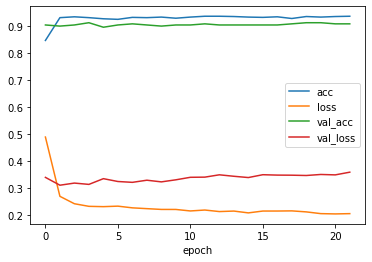

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["accuracy"], label="acc")
plt.plot(history.epoch, history.history["loss"], label="loss")
plt.plot(history.epoch, history.history["val_accuracy"], label="val_acc")
plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.legend()

### 予測

In [43]:
test_predictions = model.predict(test_data)
#最大値のインデックス
k = np.argmax(test_predictions,axis=1)
print(k)

[0 0 1 0 1 0 0 0 2 2 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 2 0
 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 1 1 0 0 0 0 2 1 0
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 2 0 2 0 2 0 0 0 2 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 2 0 0 2 0 1 0 1 2 0 0
 0 2 0 1 0 1 1 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 2 0 0 1 0 2 0 0 0 0 0 0 0 2 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0
 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0
 1 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2
 0 0 2 0 0 0 0 0 0 0 2 2 

In [44]:
sample[1] = k
sample

,0,1
0,0,0
1,3,0
2,6,1
3,7,0
4,8,1
...,...,...
795,1979,0
796,1983,0
797,1985,0
798,1989,1


### ファイル出力

In [45]:
import csv
f = open('out.csv','w',newline='')
writer = csv.writer(f)
writer.writerows(sample.values)
f.close()

In [46]:
model.save('medical_model')